In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
from scipy.stats import norm, bernoulli
from utils import ols, transform_features, get_data_small, make_ess_coverage_plot_intro
import warnings; warnings.simplefilter('ignore')
from tqdm import tqdm
import torch
from utils_optimization import MinMaxOptimizer_l2, constraint_cross_validation_regression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
features = ['AGEP','SCHL','MAR','DIS','ESP','CIT','MIG','MIL','ANC1P','NATIVITY','DEAR','DEYE','DREM','SEX','RAC1P', 'SOCP', 'COW']
ft = np.array(["q", "q", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c"])
income_features, income, employed = get_data_small(year=2019, features=features, outcome='PINCP', m= 20000)

In [16]:
n_all = len(income)
n_tr = int(n_all*0.3)

income_features_labeled, income_features_unlabeled, income_labeled, Y = train_test_split(income_features, income, train_size=n_tr)
income_labeled = income_labeled.to_numpy()

age = income_features['AGEP'].to_numpy()
sex = income_features['SEX'].to_numpy()
theta_true = ols(np.stack([age, sex], axis=1), income.to_numpy())[0]

In [17]:
X = np.stack([income_features_unlabeled['AGEP'].to_numpy(), income_features_unlabeled['SEX'].to_numpy()], axis=1)
Y = Y.to_numpy()
income_features_enc, enc = transform_features(income_features, ft)
income_features_labeled = transform_features(income_features_labeled, ft, enc)[0]

In [18]:
dtrain = xgb.DMatrix(income_features_labeled, label=income_labeled)
tree = xgb.train({'eta': 0.3, 'max_depth': 7, 'objective': 'reg:absoluteerror'}, dtrain, 2000)

In [ ]:
p = 0.03

income_features_unlabeled_bi, income_features_unlabeled_rem, label, Y_rem = train_test_split(income_features_unlabeled, Y, test_size=(1 - p))

X_bi = np.stack([income_features_unlabeled_bi['AGEP'].to_numpy(), income_features_unlabeled_bi['SEX'].to_numpy()], axis=1)
X_rem = np.stack([income_features_unlabeled_rem['AGEP'].to_numpy(), income_features_unlabeled_rem['SEX'].to_numpy()], axis=1)
X_order = np.concatenate([X_rem, X_bi], axis=0)
Y_order = np.concatenate([Y_rem, label], axis=0)
income_features_unlabeled_bi = transform_features(income_features_unlabeled_bi, ft, enc)[0]
income_features_unlabeled_rem = transform_features(income_features_unlabeled_rem, ft, enc)[0]
Yhat = tree.predict(xgb.DMatrix(income_features_unlabeled_rem))

In [ ]:
# burn-in period
error_bi = np.abs(label - tree.predict(xgb.DMatrix(income_features_unlabeled_bi)))

xgb_err = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=20)
xgb_err.fit(X_bi, error_bi)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
predicted_errs = np.clip(np.abs(xgb_err.predict(X_rem)), 0, np.inf)
Hessian_inv = np.linalg.inv(1/X_order.shape[0] * X_order.T @ X_order)
h = Hessian_inv[:,0]
uncertainty = np.abs(h.dot(X_rem.T)) * predicted_errs

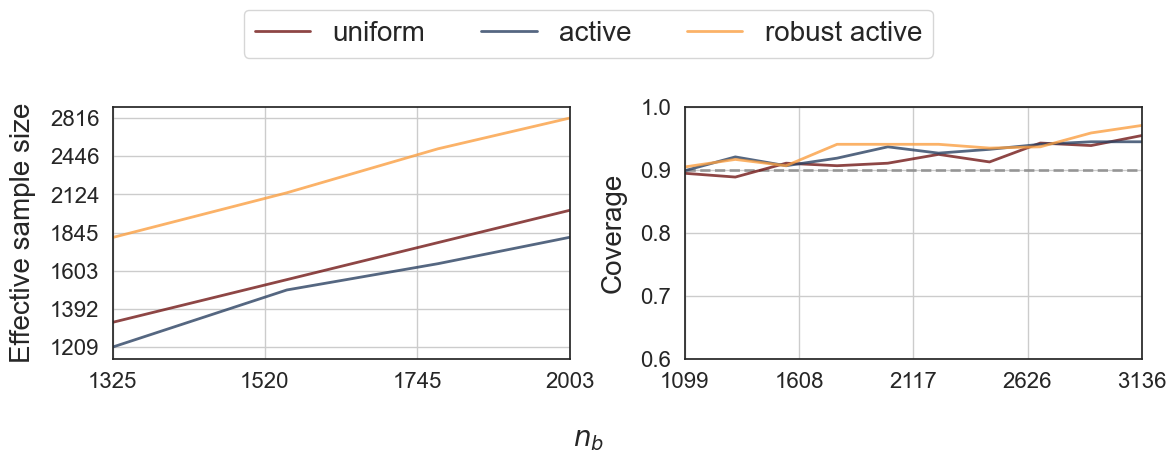

In [ ]:
# do the experiment
num_trials = 500
budgets = np.linspace(0.05, 0.2, 10)
alpha = 0.1
n = len(Y)
n_rem = len(Y_rem)

cv_list = [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
k = 5 
c_list = constraint_cross_validation_regression(X_bi, income_features_unlabeled_bi, label, tree, cv_list, k, budgets, Hessian_inv, enc, device)

tau_list = []
error = uncertainty.copy()
n_rem = len(error)
for i in range(len(budgets)):
    constraint_sum = c_list[i] * np.sqrt(n_rem)
    bg = budgets[i]
    eta = bg / np.mean(uncertainty)
    pi = np.clip(eta*uncertainty, 0.0, 1.0)
    nb = bg * n_rem
    optimizer = MinMaxOptimizer_l2(error, pi, nb, n_rem, constraint_sum)
    optimal_value, optimal_r= optimizer.optimize()
    tau_list.append(optimal_r)
results = []
columns = ["lb", "ub", "interval width", "coverage", "estimator","$n_b$"]
temp_df = pd.DataFrame(np.zeros((3,len(columns))), columns=columns)
total_time = 0
income_features_unlabeled_ = transform_features(income_features_unlabeled, ft, enc)[0]
Yhat_unif = tree.predict(xgb.DMatrix(income_features_unlabeled_))
for j in range(len(budgets)):
    bg = budgets[j]
    tau = 0.01
    eta = bg / np.mean(uncertainty)
    probs_active = np.clip((1-tau)*eta*uncertainty + tau*bg, 0.0, 1.0)

    tau = tau_list[j]
    probs_robust_active = np.clip((eta * uncertainty) ** (1-tau) * bg ** tau / np.sum((eta * uncertainty) ** (1-tau) * bg ** tau) * bg * n_rem, 0.0, 1.0)

    for i in range(num_trials):
        xi_unif = bernoulli.rvs([bg]*n_rem)
        unif_label = label
        unif_label = np.concatenate((Yhat + (Y_rem - Yhat)*xi_unif/bg, unif_label))
        pointest_unif = ols(X_order, unif_label)
        grads = (np.dot(X_order, pointest_unif) - unif_label)[:, np.newaxis] * X_order
        V = np.cov(grads.T)
        Sigma_unif = Hessian_inv @ V @ Hessian_inv
        pointest_unif_std = np.sqrt(Sigma_unif[0,0])/np.sqrt(n)
        width_unif = norm.ppf(1-alpha/2)*pointest_unif_std
        coverage_unif = (theta_true >= pointest_unif[0] - width_unif)*(theta_true <= pointest_unif[0] + width_unif)
        temp_df.loc[0] = pointest_unif[0] - width_unif, pointest_unif[0] + width_unif, 2*width_unif, coverage_unif, "uniform", int(n - (1 - bg) * n_rem)
    

        xi = bernoulli.rvs(probs_active)
        active_label = label
        active_label = np.concatenate((Yhat + (Y_rem - Yhat)*xi/probs_active, active_label))
        pointest_active = ols(X_order, active_label)
        grads = (np.dot(X_order, pointest_active) - active_label)[:, np.newaxis] * X_order
        V = np.cov(grads.T)
        Sigma_active = Hessian_inv @ V @ Hessian_inv
        pointest_active_std = np.sqrt(Sigma_active[0,0])/np.sqrt(n)
        width_active = norm.ppf(1-alpha/2)*pointest_active_std 
        coverage_active = (theta_true >= pointest_active[0] - width_active)*(theta_true <= pointest_active[0] + width_active)   
        temp_df.loc[1] = pointest_active[0] - width_active, pointest_active[0] + width_active, 2*width_active, coverage_active, "active", int(n - (1 - bg) * n_rem)


        xi = bernoulli.rvs(probs_robust_active)
        active_robust_label = label
        active_robust_label = np.concatenate((Yhat + (Y_rem - Yhat)*xi/probs_robust_active, active_robust_label))
        pointest_active_robust = ols(X_order, active_robust_label)
        grads = (np.dot(X_order, pointest_active_robust) - active_robust_label)[:, np.newaxis] * X_order

        
        V = np.cov(grads.T)
        Sigma_active_robust = Hessian_inv @ V @ Hessian_inv
        pointest_active_robust_std = np.sqrt(Sigma_active_robust[0,0])/np.sqrt(n)
        width_active_robust = norm.ppf(1-alpha/2)*pointest_active_robust_std 
        coverage_active_robust = (theta_true >= pointest_active_robust[0] - width_active_robust)*(theta_true <= pointest_active_robust[0] + width_active_robust)   
        temp_df.loc[2] = pointest_active_robust[0] - width_active_robust, pointest_active_robust[0] + width_active_robust, 2*width_active_robust, coverage_active_robust, "robust active", int(n - (1 - bg) * n_rem)
   
        
        results += [temp_df.copy()]
df = pd.concat(results,ignore_index=True)
make_ess_coverage_plot_intro(df, "regression coefficient", "ess_and_coverage_census.pdf", theta_true, less_precision=True)